# Preprocessing ND samples 

356  
381  
404  

Collab Sander and Theis Labs

Sara Jimenez

### Pre-requisites

In [1]:
# python packages 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import scvi
import os

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

# R packages -> for ambient RNA correction using SoupX
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython


[rank: 0] Global seed set to 0
/home/aih/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'anndata2ri'

In [2]:
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [2]:
results_file = 'DATA_DIR/preprocessed_nd.h5ad'  

In [ ]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata

Path to files

In [3]:
folder = '../../../../../shared_data/10x_output/'
sample = ['snRNA_MM356','snRNA_MM381','snRNA_MM404']
file_names = []
for s in sample:
    file_names.append(folder + s + '/filtered_feature_bc_matrix/')
file_names

['../../../../../shared_data/10x_output/snRNA_MM356/filtered_feature_bc_matrix/',
 '../../../../../shared_data/10x_output/snRNA_MM381/filtered_feature_bc_matrix/',
 '../../../../../shared_data/10x_output/snRNA_MM404/filtered_feature_bc_matrix/']

In [4]:
file_names[0].split('/')[7]

'snRNA_MM356'

### Preprocessing functions

We define a function that takes a metric, i.e. a column in .obs and the number of MADs (median absolute deviations) that is still permissive within the filtering strategy

In [5]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We define a preprocessing function **pp** that takes the file path and performs correction for ambient RNA, doublet removal and filtering of cells according to number of genes (get rid of cells with fewer than 200 genes) and QC covariates 

In [6]:
def pp(file_path):
    
    # Load data 
    adata = sc.read_10x_mtx(file_path,var_names='gene_symbols',cache=True) 
    
    # Ambient RNA ------------------------------------------------------------------------------------------------
    
    adata_pp = adata.copy()
    adata.obs_names_make_unique()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    # Preprocess variables for SoupX
    soupx_groups = adata_pp.obs["soupx_groups"]
    del adata_pp
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T

    adata_raw = sc.read_10x_mtx(file_path,var_names='gene_symbols',cache=True) 
    adata_raw.var_names_make_unique()
    adata_raw.obs_names_make_unique()
    data_tod = adata_raw.X.T
    del adata_raw
    
    %R library(SoupX)
    
    %R -i data -i data_tod -i genes -i cells -i soupx_groups #-o out
    # specify row and column names of data
    %R rownames(data) = genes
    %R colnames(data) = cells
    # ensure correct sparse format for table of counts and table of droplets
    %R data <- as(data, "sparseMatrix")
    %R data_tod <- as(data_tod, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    %R sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    %R soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    %R sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    %R sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    %R sc  = autoEstCont(sc, doPlot=FALSE)
    # Infer corrected table of counts and rount to integer
    %R out = adjustCounts(sc, roundToInt = TRUE)
    %R -o out 
    
    # annotate anndata and filter 
    adata.layers["counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]
    
    # Doublet removal --------------------------------------------------------------------------------------------
    
    adata_pp = adata.copy()    
    sc.pp.filter_genes(adata_pp, min_cells = 10)
    sc.pp.highly_variable_genes(adata_pp, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata_pp)
    vae = scvi.model.SCVI(adata_pp)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    del adata_pp
    
    adata.obs['Sample'] = file_path.split('/')[7] #'/shared_data/10x_output/snRNA_MM404/filtered_feature_bc_matrix/'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    # Preprocessing ----------------------------------------------------------------------------------------------
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    
    # mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    # ribosomal genes
    adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))
    # hemoglobin genes.
    adata.var['hb'] = adata.var_names.str.contains(('^HB[^(P)]'))
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo','hb'], inplace=True, percent_top=[20], log1p=True)
                                                     
    adata.obs['outlier'] = (
        is_outlier(adata, 'log1p_total_counts', 5)
        | is_outlier(adata, 'log1p_n_genes_by_counts', 5)
        | is_outlier(adata, 'pct_counts_in_top_20_genes', 5)
    )
    adata.obs.outlier.value_counts()
    adata.obs['mt_outlier'] = adata.obs['pct_counts_mt'] > 20
    adata.obs.mt_outlier.value_counts()
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    print(adata.X.shape)

    return adata

In [7]:
out_pp = []
for file in file_names:
    out_pp.append(pp(file))

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/pyt


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████████████████████| 400/400 [04:28<00:00,  1.46it/s, loss=544, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████| 400/400 [04:28<00:00,  1.49it/s, loss=544, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/external/solo/_model.py:243: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  doublets_ad = AnnData(doublets)
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next ve

Epoch 187/400:  47%|███████████▏            | 187/400 [00:22<00:25,  8.32it/s, loss=0.325, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.365. Signaling Trainer to stop.


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


(2660, 36601)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████████████████████| 400/400 [18:59<00:00,  2.85s/it, loss=452, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████| 400/400 [18:59<00:00,  2.85s/it, loss=452, v_num=1]


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/external/solo/_model.py:243: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  doublets_ad = AnnData(doublets)


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

Epoch 139/400:  35%|████████▎               | 139/400 [01:11<02:15,  1.93it/s, loss=0.273, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.255. Signaling Trainer to stop.


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


(11481, 36601)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████████████████████| 400/400 [10:53<00:00,  1.72s/it, loss=392, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████| 400/400 [10:53<00:00,  1.63s/it, loss=392, v_num=1]


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/external/solo/_model.py:243: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  doublets_ad = AnnData(doublets)


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

Epoch 267/400:  67%|████████████████▋        | 267/400 [01:27<00:43,  3.04it/s, loss=0.27, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.295. Signaling Trainer to stop.


/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


(7312, 36601)


In [9]:
adata = sc.concat(out_pp)

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata

AnnData object with n_obs × n_vars = 21453 × 36601
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    layers: 'counts', 'soupX_counts'

In [11]:
adata.obs.Sample.value_counts()

snRNA_MM381    11481
snRNA_MM404     7312
snRNA_MM356     2660
Name: Sample, dtype: int64

In [15]:
adata.layers['soupX_counts'].shape

(21453, 23146)

In [12]:
# Filter genes now that the object has a bigger amount of cells 
sc.pp.filter_genes(adata, min_cells = 10) #get rid of genes that are found in fewer than 10 cells
adata

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 21453 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells'
    layers: 'counts', 'soupX_counts'

### Normalization 

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
adata.raw = adata

In [19]:
adata

AnnData object with n_obs × n_vars = 21453 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'soupX_counts'

In [20]:
# Save data for integration with other samples 
adata.write(results_file)

### HVG

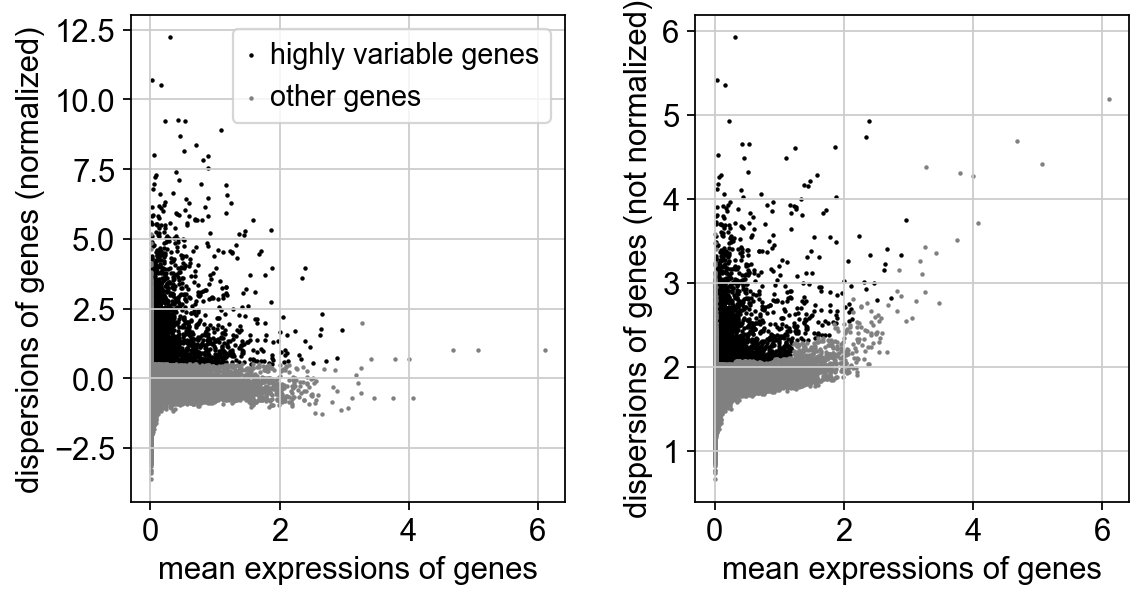

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

### Dimensionality reduction and neighborhood graph

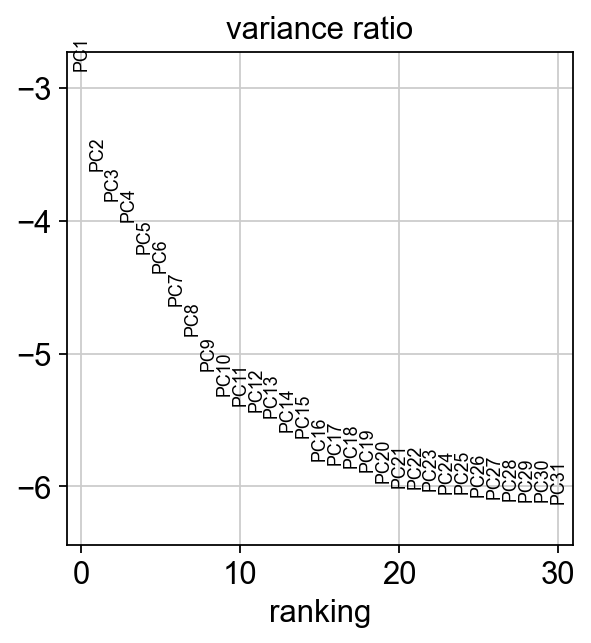

In [22]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, min_dist=0.5)

In [34]:
adata

AnnData object with n_obs × n_vars = 21453 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'soupX_counts'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pl.umap(adata, color=['INS', 'GCG','SOX9', 'AMY2A'])

In [ ]:
sc.pl.umap(adata, color=['Sample'])

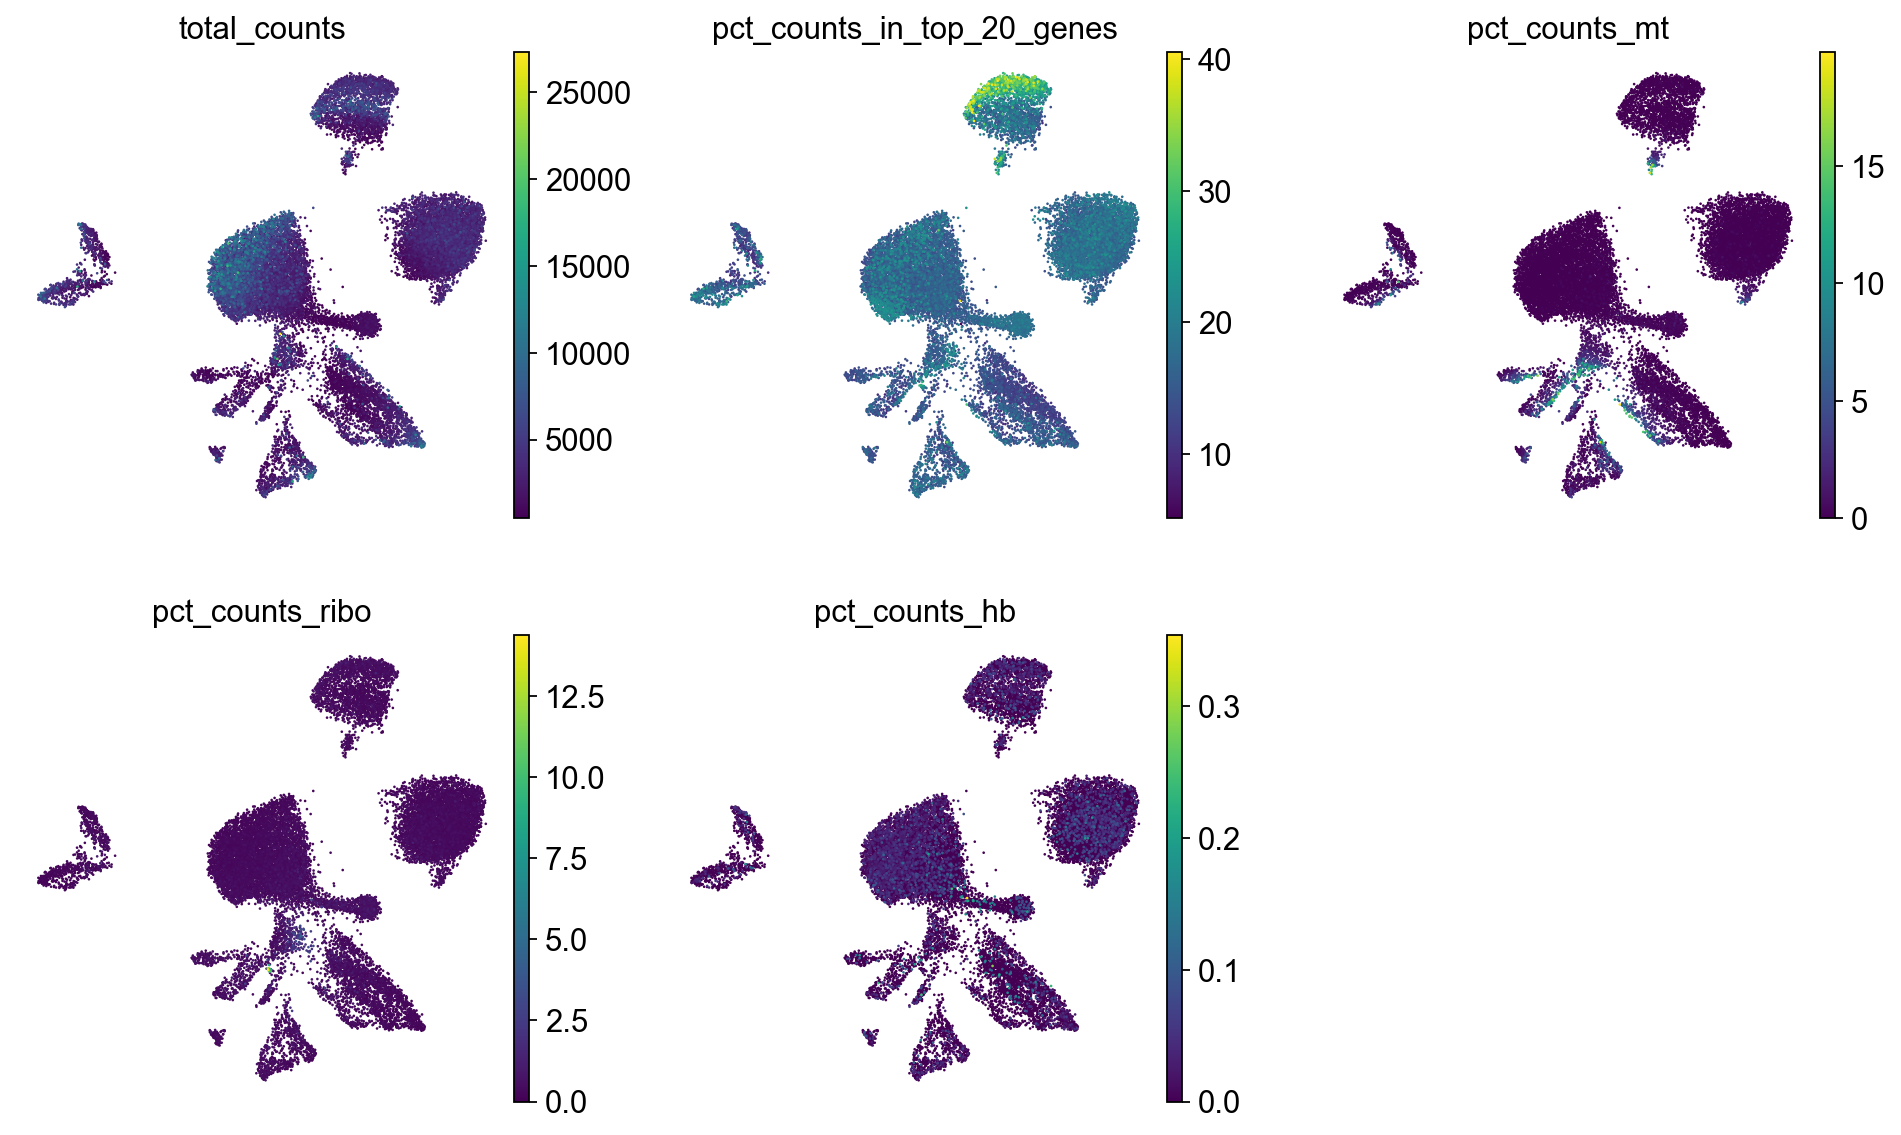

In [29]:
sc.pl.umap(adata, color=['total_counts', 'pct_counts_in_top_20_genes',
                         'pct_counts_mt', 'pct_counts_ribo','pct_counts_hb'], ncols=3)